# 提取因子的封装函数

In [5]:
# 提取因子数据

#参数及工具函数部分
import pandas as pd
import numpy as np
from jqfactor import *
import warnings  
warnings.filterwarnings('ignore')

#获取数据主函数
#输入股票池、指标名称、开始日期、结束日期
#返回行标签为日期，列表签为股票名称的dataframe表格
def get_factor_data(stockPool, factor,date_start, date_end):
    
    #获取股票池函数
    def get_stock(stockPool, begin_date):
        if stockPool == 'HS300':#用于获取沪深300股票池
            stockList = get_index_stocks('000300.XSHG', begin_date)
        elif stockPool == 'ZZ500':#用于获取中证500股票池
            stockList = get_index_stocks('399905.XSHE', begin_date)
        elif stockPool == 'ZZ800':#用于获取中证800股票池
            stockList = get_index_stocks('399906.XSHE', begin_date)   
        elif stockPool == 'A':#用于获取全部A股股票池
            stockList = get_index_stocks('000002.XSHG', begin_date) + get_index_stocks('399107.XSHE', begin_date)
        else:#自定义输入股票池
            stockList = stockPool
        return stockList    
    
    #从财务库获取数据
    def get_factor_account_data(factor,stock, date):
        if factor in val:
            q = query(valuation).filter(valuation.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in bal:
            q = query(balance).filter(balance.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in cf:
            q = query(cash_flow).filter(cash_flow.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in inc:
            q = query(income).filter(income.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in ind:
            q = query(indicator).filter(indicator.code.in_(stock))
            df = get_fundamentals(q, date)

        df.index = df['code']
        data = pd.DataFrame(index = df.index)
        data[date] = df[factor]

        return data
    
    def get_trade_days(start_date = date_start, end_date = date_end):
    
        pool = get_index_stocks('000016.XSHG')

        date_list = get_price(pool,start_date=date_start,end_date=date_end,fields=['close'])['close'].index
        return date_list
    
    
    #获取日期列表
    date_list = get_trade_days(start_date = date_start, end_date = date_end)
    #空df预备存储数据，data_ret是返回数据
    data_ret = pd.DataFrame(data = [], columns = ['date','asset','factor'])
    
    #获取五张财务基础所有指标名称
    val = get_fundamentals(query(valuation).limit(1)).columns.tolist()
    bal = get_fundamentals(query(balance).limit(1)).columns.tolist()
    cf = get_fundamentals(query(cash_flow).limit(1)).columns.tolist()
    inc = get_fundamentals(query(income).limit(1)).columns.tolist()
    ind = get_fundamentals(query(indicator).limit(1)).columns.tolist()
    all_columns = val+bal+cf+inc+ind
    
    
    # 判断相应的股票池
    # 如果stockpool是字母，则按照字母提取
    # 如果stockpool是数组，则直接赋值字母
    # 确定相应的股票池
    if isinstance(stockPool,list):
        all_stocks = stockPool
    else:
        all_stocks = get_stock(stockPool, date_end)

    #循环时间列表获取指标数据
    for date in date_list:
        
        data_temp = pd.DataFrame(data = [],columns = ['date','asset','factor'])

        #获取股票池
        #获取因子数据
        if factor in all_columns: #可以从财务库直接取到因子值的因子
            data_temp['factor'] = get_factor_account_data(factor,all_stocks, date).iloc[:,0]
        
        
        # 改造成alphalen需要格式
        # 确定资产名称
        data_temp['asset'] =  get_factor_account_data(factor,all_stocks, date).index
        
        # 确定日期
        data_temp['date'] =  np.array([date for i in range(0,data_temp.shape[0])])
        
        
        # 删除原先的索引
        data_temp = data_temp.reset_index()
        data_temp = data_temp.drop(['code'],axis=1)
        
        data_ret = pd.concat([data_ret, data_temp], axis = 0) 
        

        # 如果不需要则进行正常的数据合并
        #         data = pd.concat([data, data_temp], axis = 0) 

    # 确定 multi_index
    data_ret = data_ret.set_index(['date','asset'])
    return data_ret



# 去极值、中性化、标准化的封装函数

In [6]:
from sklearn.linear_model import LinearRegression

def mad(factor):
    # 3倍中位数去极值
    # 确定输入变量
    factor = np.array(factor)
        
    # 求出因子值的中位数
    med = np.median(factor)

    # 求出因子值与中位数的差值，进行绝对值
    mad = np.median(abs(factor - med))

    # 定义几倍的中位数上下限
    high = med + (3 * 1.4826 * mad)
    low = med - (3 * 1.4826 * mad)

    # 替换上下限以外的值
    factor = np.where(factor > high, high, factor)
    factor = np.where(factor < low, low, factor)
    
    # 因为np处理后会将数据由[x]变为[[x]]的数据，所以进行处理
    ret = factor
    return ret


def stand(factor):
    factor = np.array(factor)
    mean = factor.mean()
    std = factor.std()
    return (factor - mean)/std
    
# factor1：主参数，一般为需要被中性化的参数
# factor2：被动参数，一般作为参考想象，一般是市值作为中性化的参考参数
def neutral(factor1,factor2):
    # 统一类型
    factor1 = np.array(factor1)
    factor2 = np.array(factor2)
    
    # 去除0值
    factor1[np.isnan(factor1)] = 0
    factor2[np.isnan(factor2)] = 0

    
    # 根据LinearRegression的要求需要将参数做reshape的处理
    # python 3 在这里有一错误，所以要增加values的设置
    # x = factor2.values.reshape(-1,1)
    # y = factor1.values.reshape(-1,1)
    
    # 注意：以下代码为np的reshape（pandas的reshape与np的reshape略有不同）
    x = np.reshape(factor2,(-1,1))
    y = np.reshape(factor1,(-1,1))
    try:
        # 建立回归方程并预测
        lr = LinearRegression()
        lr.fit(x, y)
        y_predict = lr.predict(x)
    except:
        print("出错，未进行中性化")
        # 如果出错，则预测值统一列为0，保持原值
        y_predict = 0
        
    # 去除线性的关系，留下误差作为该因子的值
    res = y - y_predict   
    
    # 因为np处理后会将数据由[x]变为[[x]]的数据，所以进行处理
    return [d[0] for d in res]

# 在上面Neutral函数的基础上，对原始数据中性化

- 逐日期进行，对每个截断面数据进行操作
- 每个日期按照去极值、市值中性化、标准化的流程进行

In [7]:
from datetime import datetime

from sklearn.linear_model import LinearRegression


def neutral_data_by_market_cap(factor_input):
    
    factor_data = factor_input
    
    # 遍历每一个日期
    for date_i in set([index[0] for index, row in factor_data.iterrows()]):
    # for date_i in [datetime.strptime('2016-01-11', '%Y-%m-%d')]:

        # print(date_i)
        # 临时赋值使用的factor_temp_pd
        factor_temp_np = pd.DataFrame()
        factor_refer = pd.DataFrame()


        # 提取每一个日期的股票编码列表
        sec_list = []
        sec_list = list(factor_data.loc[(date_i)].index)

        factor_temp_np = np.array(factor_data.loc[(date_i),'factor'])

        # 去极值
        factor_temp_np = mad(factor_temp_np)

        # 中性化 
        # 提取参考的市值因子
        factor_refer = get_factor_data(sec_list,'market_cap',date_i,date_i)
        factor_refer = factor_refer.loc[(date_i),'factor']

        factor_temp_np = neutral(factor_temp_np,factor_refer)

        # 标准化
        factor_temp_np = stand(factor_temp_np)

        # 赋值
        factor_data.loc[(date_i),'factor'] = np.array(factor_temp_np)
        
    return factor_data

In [39]:
# IC分析
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

# alphalen数据清理
from alphalens.utils import get_clean_factor_and_forward_returns


# 关闭告警
import warnings
warnings.filterwarnings("ignore")

# 设置因子池、倒置控制数组
factor_pool = ['pe_ratio','pb_ratio','market_cap']
if_reverse = [1,1,1]

# 设置起始、终止日期
begin_date = '2016-1-10'
end_date = '2017-1-10'


factor_total_pd = pd.DataFrame()


# 开始因子循环
for i in range(0,len(factor_pool)):
# for i in range(0,1):

    # 因子赋值
    factor_i = factor_pool[i]
    if_reverse_i = if_reverse[i]
    
    print("$$处理因子值：%s"%str(factor_i))
    
    
    # 提取因子
    # 示例，获取沪深300成分股在2019年前两个月的市盈率数据
    # 注意：每次只能提取1个因子
    factor_data = get_factor_data('HS300', factor_i,begin_date, end_date)
    factor_data = factor_data.fillna(0)
    
    # 确定是否取倒数
    if if_reverse_i:
        factor_data['factor'] = 1/factor_data['factor']
        print("--取倒数")
    print("--提取因子完成")

        
    # 去极值、中性化、标准化
    factor_data = neutral_data_by_market_cap(factor_data)
    
    print("--数据中性化完成")

    # 数据合并
    # 更改列名
    factor_data.rename(columns={'factor':factor_i}, inplace = True)
    
    factor_total_pd = pd.concat([factor_total_pd,factor_data],axis = 1)
    print("--数据合并完成")



$$处理因子值：pe_ratio
--取倒数
--提取因子完成
--数据中性化完成
--数据合并完成
$$处理因子值：pb_ratio
--取倒数
--提取因子完成
--数据中性化完成
--数据合并完成
$$处理因子值：market_cap
--取倒数
--提取因子完成
--数据中性化完成
--数据合并完成


In [40]:
factor_total_pd['factor'] = 0
for col in factor_pool:
    factor_total_pd['factor'] = factor_total_pd[col] + factor_total_pd['factor'] 

In [41]:
factor_total_pd

pe_ratio  pb_ratio  market_cap    factor
date       asset                                                
2016-01-11 000001.XSHE  2.147474  2.363557   -1.299684  3.211347
           000002.XSHE  0.071667 -0.794919   -1.150035 -1.873287
           000008.XSHE -0.939351 -1.011503    1.139699 -0.811155
           000009.XSHE -0.086100 -0.611959    1.567507  0.869448
           000027.XSHE  0.831029  1.319171    0.405968  2.556167
           000039.XSHE  0.370795  0.463946   -0.511566  0.323176
           000060.XSHE -0.879031 -0.326426    0.886799 -0.318658
           000061.XSHE -0.962563 -0.627200    1.232676 -0.357087
           000063.XSHE  0.324090  0.117622   -0.868484 -0.426772
           000069.XSHE  0.968034  0.943872   -0.768048  1.143858
           000100.XSHE  0.721324  0.600001   -0.433946  0.887379
           000156.XSHE -0.611542 -0.386693    0.208127 -0.790109
           000157.XSHE -1.754724  2.775773   -0.087299  0.933750
           000166.XSHE  0.566374 -0.287019   -1.278730 -0.999375
           000333.XSHE  1.596635 -0.139378   -1.265380  0.191876
           000338.XSHE  0.269838  2.313923    0.175620  2.759381
           000402.XSHE  2.336677  2.154979    0.683169  5.174825
           000413.XSHE  0.051567  0.807046    0.763778  1.622391
           000415.XSHE -0.361962  0.922199   -0.386763  0.173474
           000423.XSHE  0.388575 -0.622019    0.441923  0.208479
           000425.XSHE -1.614300  1.937046    0.885668  1.208415
           000503.XSHE -1.142343 -1.255234    1.565211 -0.832365
           000538.XSHE -0.012622 -0.818442   -0.896322 -1.727386
           000540.XSHE  0.752140 -0.397616    0.159857  0.514381
           000555.XSHE -0.759450 -1.101231    0.422721 -1.437960
           000559.XSHE -0.494808 -1.087931   -0.008935 -1.591673
           000568.XSHE -0.246737 -0.232493    0.264419 -0.214811
           000623.XSHE  2.063194  1.600188    1.318281  4.981663
           000625.XSHE  2.331291  0.274231   -0.920027  1.685494
           000627.XSHE -1.331472 -0.927920    3.931719  1.672327
...                          ...       ...         ...       ...
2017-01-10 601628.XSHG -1.794562 -1.640774    0.008181 -3.427155
           601633.XSHG  1.494440 -0.018952   -1.162202  0.313286
           601668.XSHG  2.061320  0.453735   -1.146497  1.368558
           601669.XSHG  0.538182  0.526445   -1.141924 -0.077297
           601688.XSHG  0.339840  0.818881   -1.245235 -0.086514
           601718.XSHG -0.353862 -0.036629    0.124066 -0.266425
           601727.XSHG -0.720399 -0.214135   -1.206024 -2.140558
           601766.XSHG -0.303162 -0.764523   -1.130652 -2.198337
           601788.XSHG  0.508384  0.975296   -0.942098  0.541581
           601800.XSHG  0.575530  0.131629   -1.180863 -0.473703
           601818.XSHG  2.224609  2.873488   -1.263818  3.834279
           601857.XSHG -3.901082 -2.311673    2.474482 -3.738273
           601866.XSHG -2.654115 -0.522780   -0.467072 -3.643967
           601872.XSHG  0.370238  0.792713    0.768292  1.931244
           601877.XSHG  0.326719  0.229503   -0.003098  0.553124
           601888.XSHG  0.067670 -0.502671   -0.243879 -0.678880
           601899.XSHG -0.603455 -0.231629   -0.942327 -1.777411
           601901.XSHG  0.202619  0.674067   -0.795513  0.081173
           601919.XSHG -2.668458 -0.346798   -0.660430 -3.675686
           601928.XSHG  0.246982  0.106256    0.768996  1.122234
           601933.XSHG -0.623443 -0.095295   -0.478563 -1.197301
           601939.XSHG -0.082183 -0.278741    1.963964  1.603040
           601958.XSHG -1.098586  0.481163    0.962856  0.345433
           601985.XSHG -0.125673 -0.359752   -1.199535 -1.684960
           601988.XSHG  0.614325  0.687830    0.895397  2.197552
           601989.XSHG -1.598154 -0.202327   -1.259237 -3.059718
           601998.XSHG  1.941677  2.103207   -1.015692  3.029193
           603000.XSHG -0.766777 -1.102726    1.870088  0.000586
           603885.XSHG  0.238128 -0.686351    0.440783 -0.0

Dropped 4.1% entries from factor data (4.1% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Information Analysis


,1,5,10
IC Mean,0.046,0.077,0.099
IC Std.,0.111,0.119,0.126
Risk-Adjusted IC,0.417,0.651,0.784
t-stat(IC),6.388,9.983,12.018
p-value(IC),0.000,0.000,0.000
IC Skew,0.138,0.088,0.344
IC Kurtosis,-0.253,-0.440,-0.567


<Figure size 432x288 with 0 Axes>

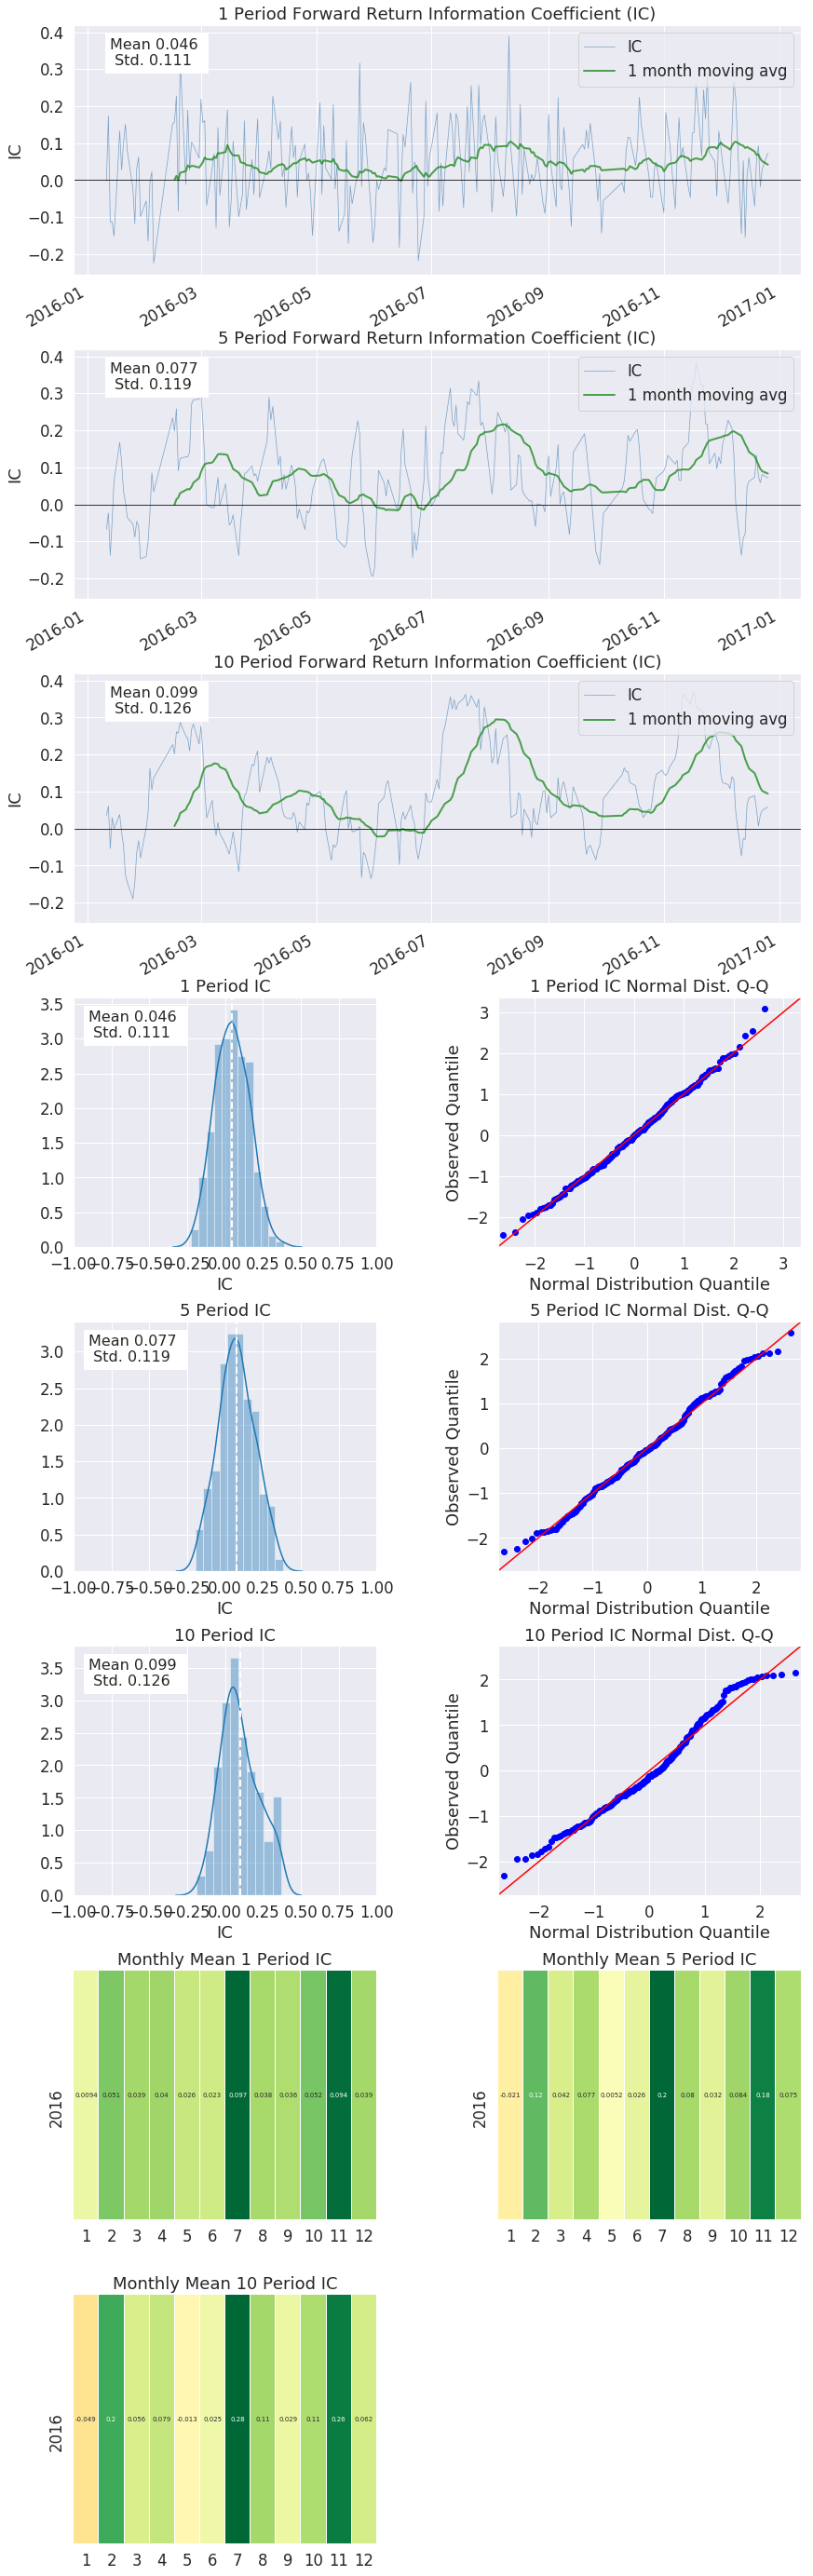

In [42]:
# 严格意义应在循环外处理
# 此处仅为示例
# 提取价格数据
all_stocks = list(set([index[1] for index, row in factor_data.iterrows()]))
price_data = get_price(all_stocks,start_date=begin_date , end_date = end_date,fields=['close'])['close']


# 数据清洗
merged_data = get_clean_factor_and_forward_returns(
  factor=factor_total_pd['factor'], 
  prices=price_data
)

create_information_tear_sheet(merged_data)